In [26]:
import pandas as pd
from surprise import Reader, Dataset, accuracy
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from tqdm.notebook import tqdm
from surprise.model_selection import train_test_split
from surprise import dump

## Carrega dados dos matches
Desenvolvidos no notebook match preprocess.ipynb

In [2]:
df_rating = pd.read_csv("../data/matches2.csv")

In [3]:
df_rating.drop(columns=['Unnamed: 0'], inplace=True)
print(df_rating.shape)
df_rating.head()

(21000000, 3)


,id_posicao,id_trabalhador,rating
0,d93af0f9-a8ab-4715-b35e-5639112e620e,1268017,0
1,55fd4744-b20f-4c07-ad27-332f1ebb580c,1268017,1
2,b3cb53ef-36ad-4999-ba8a-d22cb9a0e33e,1268017,1
3,696a1e3f-b335-451d-b51e-e1d32c823fc0,1268017,1
4,362be614-4d3c-40db-a0be-67b742002b14,1268017,1


### Distribuição das notas de associação entre os trabalhadores e as posições

In [4]:
df_rating.rating.value_counts().plot.bar();

In [5]:
#df_rating[df_rating['rating']==0].shape
df_rating = df_rating.sample(2000000)

In [6]:
reader = Reader(rating_scale=(0, 3))
data = Dataset.load_from_df(df_rating[['id_trabalhador','id_posicao','rating']], reader)


In [7]:
# del(df_rating)

## Avalia alguns modelos

In [9]:
list_models = [SVD(), NormalPredictor(), KNNBasic(), CoClustering()]

benchmark = []
# Iterate over all algorithms

for algorithm in tqdm(list_models, total=len(list_models)):
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.



,test_rmse,fit_time,test_time
Algorithm,,,
KNNBasic,0.114385,13.653772,127.607379
CoClustering,0.135676,36.671393,7.835327
SVD,0.140370,56.657467,6.466326
NormalPredictor,0.627388,2.598963,6.717974


## Escolhe o modelo com melhor desempenho

In [8]:
trainset, testset = train_test_split(data, test_size=.25)

In [9]:
algo = KNNBasic()
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [10]:
accuracy.rmse(predictions)

RMSE: 0.1010


0.10103044453344062

In [11]:
predictions[:10]

[Prediction(uid=2555915, iid='ff596d1a-a1ec-467f-afb6-0219e7d87fe6', r_ui=0.0, est=0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=654700, iid='4a2ed9a9-69e5-4053-9010-00cb336eb22b', r_ui=2.0, est=1.05, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=789316, iid='c360bd5e-51ed-40c3-b8ae-ed1623a6a128', r_ui=0.0, est=0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=949751, iid='4c528d7a-c27d-44b4-81f3-87bbe58a6518', r_ui=0.0, est=0.025, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=283276, iid='df2ebe35-9b41-4b0f-84e7-18008c1206e0', r_ui=0.0, est=0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1275251, iid='2148db9c-9487-4c42-a6b4-ea382a1b9a08', r_ui=0.0, est=0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=945220, iid='0fa9e0a1-99ea-4ac3-b36c-8fe319109e98', r_ui=1.0, est=1.0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2931102, iid='

## Testa previsão de match com os dados brutos

In [12]:
df_rating[:1]

,id_posicao,id_trabalhador,rating
592059,45c7e0a2-cfd3-42d2-a4cb-3135b8da31b0,656919,1


In [13]:
id_posicao = str('c2b5abaa-0cc1-4124-9469-0a017beb319f')
id_trabalhador = 473833
algo.predict(id_trabalhador, id_posicao)

Prediction(uid=473833, iid='c2b5abaa-0cc1-4124-9469-0a017beb319f', r_ui=None, est=1.025, details={'actual_k': 40, 'was_impossible': False})

In [32]:
rating_results = []
for index, row in df_rating[:500000].iterrows():
    id_posicao = str(row.id_posicao)
    id_trabalhador = row.id_trabalhador
    #print(algo.predict(id_trabalhador, id_posicao))
    prediction_rating = algo.predict(id_trabalhador, id_posicao).est
    rating_results.append({'id_posicao':id_posicao,'id_trabalhador':id_trabalhador, 'prediction_rating':prediction_rating})

In [33]:
df_results = pd.DataFrame(rating_results)
print(df_results.shape)
df_results.head()

(500000, 3)


,id_posicao,id_trabalhador,prediction_rating
0,45c7e0a2-cfd3-42d2-a4cb-3135b8da31b0,656919,1.0
1,087039ab-9a84-4f7c-a928-451d002d2e20,3092079,0.0
2,941fdd86-c783-479a-9850-72cfa4d08c16,2531415,0.0
3,59da28f6-7fc0-4b09-8633-007edd007607,232869,0.0
4,37dbfbed-1282-4b96-877c-a64c132dceba,490107,0.0


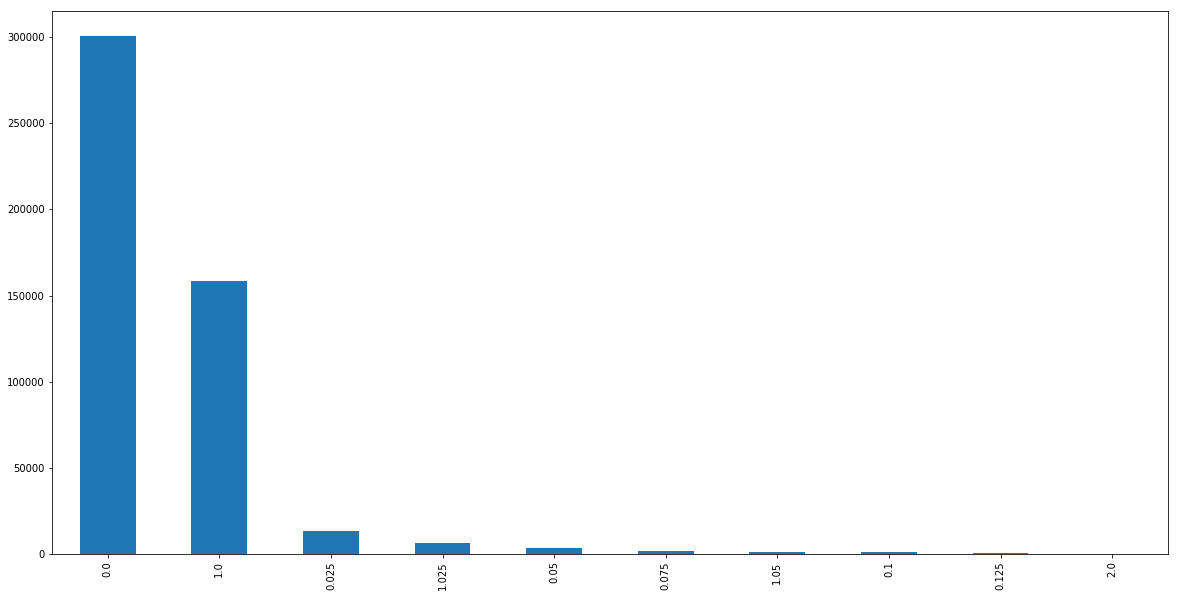

In [34]:
df_results.prediction_rating.value_counts()[:2].plot.bar(figsize=(20,10));

In [35]:
df_results.prediction_rating.value_counts()[:2]

0.000    300284
1.000    158371
0.025     13611
1.025      6713
0.050      3667
0.075      1799
1.050      1108
0.100      1090
0.125       570
2.000       342
Name: prediction_rating, dtype: int64

In [36]:
df_results.head()

,id_posicao,id_trabalhador,prediction_rating
0,45c7e0a2-cfd3-42d2-a4cb-3135b8da31b0,656919,1.0
1,087039ab-9a84-4f7c-a928-451d002d2e20,3092079,0.0
2,941fdd86-c783-479a-9850-72cfa4d08c16,2531415,0.0
3,59da28f6-7fc0-4b09-8633-007edd007607,232869,0.0
4,37dbfbed-1282-4b96-877c-a64c132dceba,490107,0.0


In [38]:
df_results.to_csv("../data/match_database.csv", index=False)

### Procura as melhores sugestões para um trabalhador

In [19]:
df_trabalhadores = pd.read_csv("../data/D_ETL_IMO_EXTRACAO_SINE_ABERTO_TRABALHADORES_SP.csv", sep=";", encoding="iso8859-1")

/home/chris/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
df_trabalhadores['id'] = df_trabalhadores.index
df_trabalhadores[df_trabalhadores['id']==2829159]

,NACIONALIDADE,DEFICIENCIAS,BAIRRO,CEP,CODIGO_MUNICIPIO_IBGE,NOME_MUNICIPIO,UF,ESCOLARIDADE,ESTUDANTE,CURSOS_PROFISSIONALIZANTES,...,POS_GRADUACOES,IDIOMAS,HABILITACAO,VEICULOS,DISP_VIAJAR,DISP_DORMIR_EMP,DISP_AUSENTAR_DOMIC,PRETENSOES,MUNICIPIOS_INTERESSE,id
2829159,BRASILEIRA,NaN,JARDIM SANTA CECILIA,7123240,351880,GUARULHOS,SP,Médio Completo,N,NaN,...,NaN,NaN,B,N,N,N,N,"411005-Auxiliar de escritorio(N,21,0,Indiferen...",NaN,2829159


In [21]:
df_results[df_results['id_trabalhador']==2829159].sort_values(by=['prediction_rating'], ascending=False).head(10)

,id_posicao,id_trabalhador,prediction_rating
4834,8bb17d0d-ce9e-482b-9393-3bf84de28171,2829159,1.0


### Procura os melhores trabalhadores para uma posição

In [22]:
df_vagas = pd.read_csv("../data/vagas_mock.csv")

In [23]:
df_vagas[df_vagas['id_empresa']=='8420aae7-7128-4120-b915-249587933cd2']

,cidade,escolaridade,graduacao,id_empresa,industria,nome_empresa,posicao
15857,SAO VICENTE,Médio Completo,Nenhum,8420aae7-7128-4120-b915-249587933cd2,Energia,extend holistic partnerships,414140-Auxiliar de logistica


In [24]:
df_results[df_results['id_posicao']=='8420aae7-7128-4120-b915-249587933cd2'].sort_values(by=['prediction_rating'], ascending=False).head(10)

,id_posicao,id_trabalhador,prediction_rating
400,8420aae7-7128-4120-b915-249587933cd2,3232129,1.0
2307,8420aae7-7128-4120-b915-249587933cd2,1068876,0.0
4969,8420aae7-7128-4120-b915-249587933cd2,2931932,0.0


In [25]:
df_trabalhadores[df_trabalhadores['id']==895873]

,NACIONALIDADE,DEFICIENCIAS,BAIRRO,CEP,CODIGO_MUNICIPIO_IBGE,NOME_MUNICIPIO,UF,ESCOLARIDADE,ESTUDANTE,CURSOS_PROFISSIONALIZANTES,...,POS_GRADUACOES,IDIOMAS,HABILITACAO,VEICULOS,DISP_VIAJAR,DISP_DORMIR_EMP,DISP_AUSENTAR_DOMIC,PRETENSOES,MUNICIPIOS_INTERESSE,id
895873,BRASILEIRA,NaN,NaN,11330200,355100,SAO VICENTE,SP,Médio Completo,N,NaN,...,NaN,NaN,Nenhum,N,N,N,N,"421125-Operador de caixa(N,36,0,Indiferente)",NaN,895873


## Persist model

In [45]:
dump.dump('../models/surprise-knn.pkl', algo=algo, verbose=1)

The dump has been saved as file ../models/surprise-knn.pkl


In [46]:
algo = dump.load('../models/surprise-knn.pkl')
algo[1].predict(id_trabalhador, id_posicao)

Prediction(uid=800493, iid='e6fad8c5-1624-4db0-929c-bcf63ec618f5', r_ui=None, est=1.0, details={'actual_k': 40, 'was_impossible': False})